### Importing libraries

In [88]:
''' Here we shall import all the necessary libraries and functions that we will be using during the tasks. '''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
import pickle

import warnings
warnings.filterwarnings("ignore")

### Device

In [2]:
''' We decide which device - CPU or GPU - to use for the training purposes. '''

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


### Data import and analysis

In [3]:
''' We import the dataset from csv file, convert it to dataframe and load the dataset in the form of tensors. Then we split the dataset into training, validation and 
testing datasets. We also check the shape of the dataset. '''

' We import the dataset from csv file, convert it to dataframe and load the dataset in the form of tensors. Then we split the dataset into training, validation and \ntesting datasets. We also check the shape of the dataset. '

In [4]:
df = pd.read_csv('../Lab 5/AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
# Number of missing values in the dataset.

print("Missing values in data \n", df.isnull().sum())

# Statistics of the dataset.

df.describe()

Missing values in data 
 #Passengers    0
dtype: int64


,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


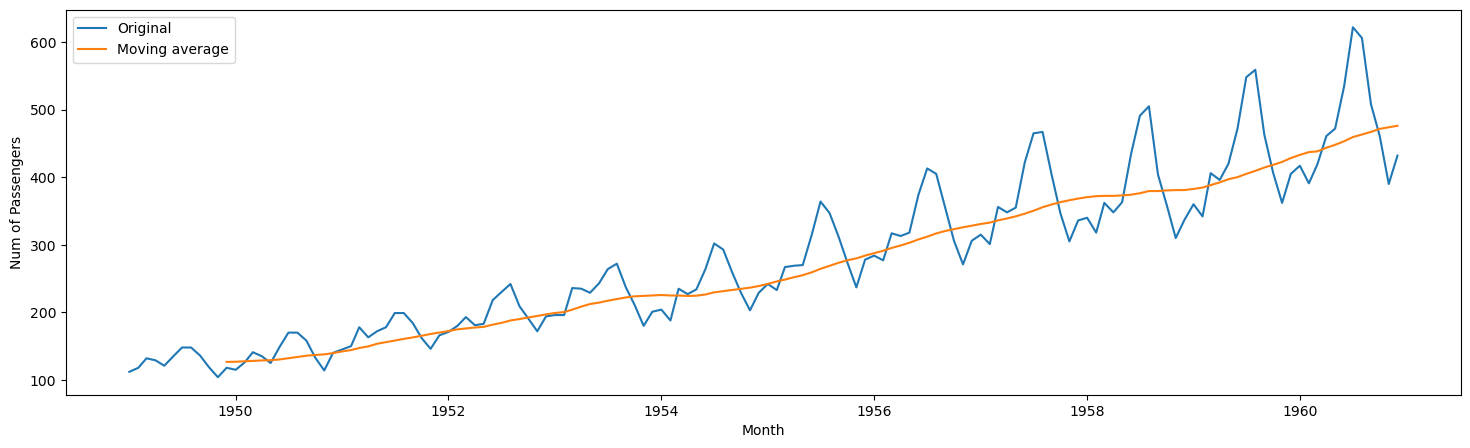

In [6]:
# Plotting the serial data to observe trends along with Moving Average of the series and Cumulative count of the series.

plt.figure(figsize=(18,5))
plt.plot(df['#Passengers'], label='Original')
plt.plot(df['#Passengers'].rolling(window=12).mean(), label='Moving average')
plt.xlabel('Month')
plt.ylabel('Num of Passengers')
plt.legend()
plt.show()

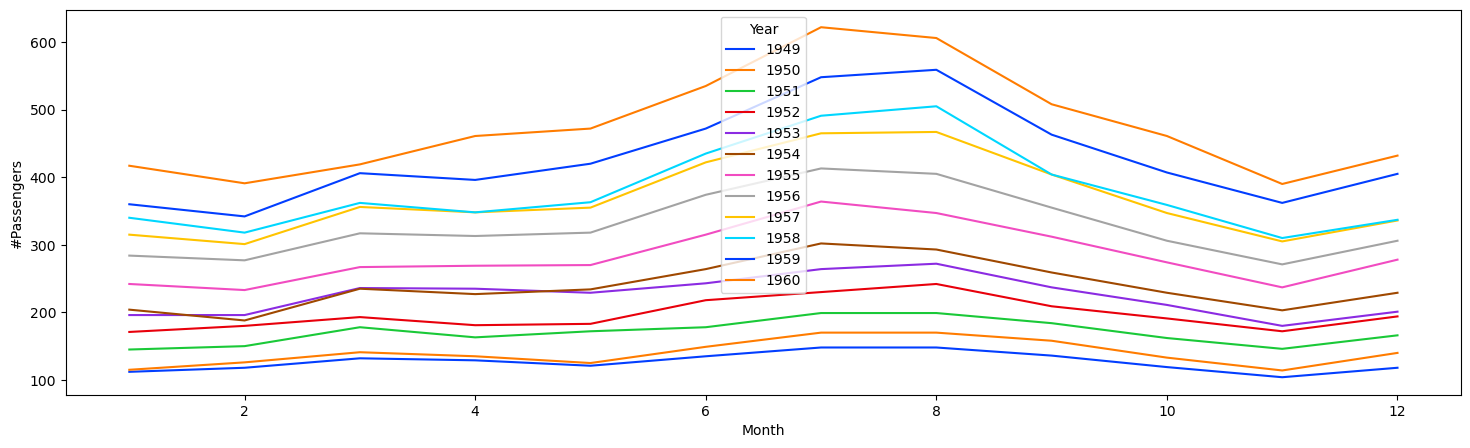

In [7]:
# Cyclic plot to observe the trend and seasonality.

df['Year'] = df.index.year
df['Month'] = df.index.month

plt.figure(figsize=(18,5))
sns.lineplot(x='Month', y='#Passengers', hue='Year', data=df, palette='bright')
plt.show()

In [8]:
df = pd.read_csv('../Lab 5/AirPassengers.csv')

scaler = MinMaxScaler()
df['Passengers'] = scaler.fit_transform(df['#Passengers'].values.reshape(-1,1))
df.drop(['#Passengers'], axis=1, inplace=True)
df.head(5)

,Month,Passengers
0,1949-01,0.015444
1,1949-02,0.027027
2,1949-03,0.054054
3,1949-04,0.048263
4,1949-05,0.032819


### Hyperparameters

In [47]:
''' We define all the necessary training hyperparameters such as batch_size, number of epochs, learning rate, etc. '''

# IN CASE OF LSTM, WE ALSO HAVE A NEW HYPERPARAMETER - 
''' LOOKBACK/SEQUENCE LENGTH '''
# It decides how many previous time steps to consider for the prediction of the next time step.

' LOOKBACK/SEQUENCE LENGTH '

In [48]:
''' FIXED HYPERPARAMETERS '''

seed = 42   # for reproducibility
torch.manual_seed(seed)     # set seed for torch
torch.backends.cudnn.benchmark = False 
torch.backends.cudnn.deterministic = True 
batch_size = 16
epochs = 200

In [49]:
''' TUNABLE HYPERPARAMETERS '''

lookbacks = [5, 6, 7, 8, 9, 10]   # sequence length
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]    

### Model Architecture

In [50]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_stacked_layers, lookback):

        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.lookback = lookback



    def prepare_loaders_for_lstm(self, df):

        shifted_df = dc(df)
        
        for i in range(1, self.lookback+1):
            shifted_df[f'Passengers(t-{i})'] = df['Passengers'].shift(i)

        shifted_df.dropna(inplace=True)
        shifted_df.set_index('Month', inplace=True)

        train_data, test_data = train_test_split(shifted_df, test_size=0.15, shuffle=False, random_state=42)
        train_data, val_data = train_test_split(train_data, test_size=0.15/0.8, shuffle=False, random_state=42)

        train_X = train_data.drop(['Passengers'], axis=1).to_numpy().reshape(-1, self.lookback, 1)
        train_y = train_data['Passengers'].to_numpy().reshape(-1, 1)
        val_X = val_data.drop(['Passengers'], axis=1).values.reshape(-1, self.lookback, 1)
        val_y = val_data['Passengers'].values.reshape(-1, 1)
        test_X = test_data.drop(['Passengers'], axis=1).values.reshape(-1, self.lookback, 1)
        test_y = test_data['Passengers'].values.reshape(-1, 1)

        # Converting to input and output tensors.

        train_X, train_y = torch.tensor(train_X, dtype=torch.float32).to(device), torch.tensor(train_y, dtype=torch.float32).to(device)
        val_X, val_y = torch.tensor(val_X, dtype=torch.float32).to(device), torch.tensor(val_y, dtype=torch.float32).to(device)
        test_X, test_y = torch.tensor(test_X, dtype=torch.float32).to(device), torch.tensor(test_y, dtype=torch.float32).to(device)

        train_loader = DataLoader(list(zip(train_X, train_y)), batch_size=16, shuffle=True)
        val_loader = DataLoader(list(zip(val_X, val_y)), batch_size=16, shuffle=False)
        test_loader = DataLoader(list(zip(test_X, test_y)), batch_size=16, shuffle=False)
        

        return train_loader, val_loader, test_loader



    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)  # Fix: initialize hidden state with correct shape
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)  # Fix: initialize cell state with correct shape

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [51]:
def train_one_epoch(model, train_loader, loss_function, optimizer):
    model.train(True)
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = running_loss / len(train_loader)

    return model, avg_loss


In [52]:
def validate_one_epoch(model, test_loader, loss_function):
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)

    return avg_loss


### Best Hyperparameters

In [71]:
# We shall first vary the lookback parameter and keep the learning rate constant.

all_errors_for_lookbacks = []

for lookback in lookbacks:

    print("\nLookback = ", lookback)

    model = LSTM(1, 64, 1, lookback).to(device)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    train_loader, val_loader, test_loader = model.prepare_loaders_for_lstm(df)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
            
        model, train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer)
        val_loss = validate_one_epoch(model, val_loader, loss_fn)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch: {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}")
    
    all_errors_for_lookbacks.append(val_loss)



Lookback =  5
Epoch: 0, Train Loss: 0.027516044365863006, Val Loss: 0.033190399408340454
Epoch: 1, Train Loss: 0.018199040088802576, Val Loss: 0.10498803853988647
Epoch: 2, Train Loss: 0.015643949154764414, Val Loss: 0.03853435255587101
Epoch: 3, Train Loss: 0.013463826462005576, Val Loss: 0.041807377710938454
Epoch: 4, Train Loss: 0.010217259482791027, Val Loss: 0.03239891491830349
Epoch: 5, Train Loss: 0.007722331288581093, Val Loss: 0.018990217708051205
Epoch: 6, Train Loss: 0.005664562884097298, Val Loss: 0.030153857544064522
Epoch: 7, Train Loss: 0.007527683318282167, Val Loss: 0.02278918121010065
Epoch: 8, Train Loss: 0.006103551131673157, Val Loss: 0.01888658758252859
Epoch: 9, Train Loss: 0.005627489066682756, Val Loss: 0.01772454846650362
Epoch: 10, Train Loss: 0.005066917355482777, Val Loss: 0.017388510052114725
Epoch: 11, Train Loss: 0.0049474289796004696, Val Loss: 0.01772304531186819
Epoch: 12, Train Loss: 0.00518834365842243, Val Loss: 0.017517646308988333
Epoch: 13, Tra

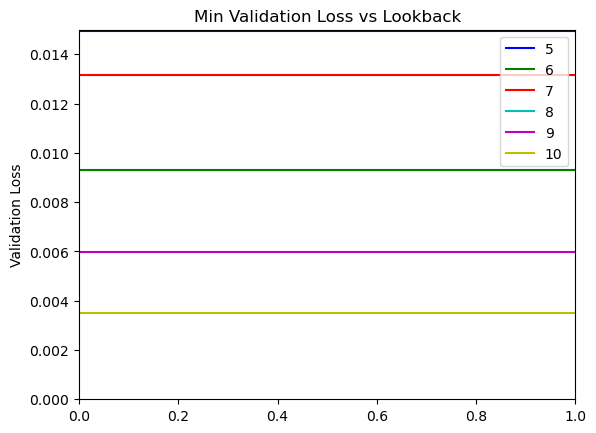

In [72]:
c = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i in range(len(all_errors_for_lookbacks)):
    lookback = lookbacks[i]
    val_loss_value = all_errors_for_lookbacks[i]
    plt.axhline(y=val_loss_value, label=lookback, color=c[i])

plt.ylabel('Validation Loss')
plt.title('Min Validation Loss vs Lookback')
plt.ylim(0, 0.015)
plt.legend()
plt.show()

In [79]:
# So we know that for lookback = 10, we get the least validation loss. Now we shall vary the learning rate and keep the lookback constant.

best_lookback = 10

In [80]:
final_errors_for_lrates = []

for learning_rate in learning_rates:

    print("\nLearning rate = ", learning_rate)

    model = LSTM(1, 64, 1, best_lookback).to(device)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader, val_loader, test_loader = model.prepare_loaders_for_lstm(df)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
            
        model, train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer)
        val_loss = validate_one_epoch(model, val_loader, loss_fn)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch: {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}")
    
    final_errors_for_lrates.append(val_loss)



Learning rate =  0.001
Epoch: 0, Train Loss: 0.11313277607162793, Val Loss: 0.2837957367300987
Epoch: 1, Train Loss: 0.062108421698212624, Val Loss: 0.17465468496084213
Epoch: 2, Train Loss: 0.026133858909209568, Val Loss: 0.07214671187102795
Epoch: 3, Train Loss: 0.018879130793114502, Val Loss: 0.029798924922943115
Epoch: 4, Train Loss: 0.019926758172611397, Val Loss: 0.05383700504899025
Epoch: 5, Train Loss: 0.016143369643638533, Val Loss: 0.076906006783247
Epoch: 6, Train Loss: 0.015699656680226326, Val Loss: 0.0759589895606041
Epoch: 7, Train Loss: 0.015355077261726061, Val Loss: 0.05920172855257988
Epoch: 8, Train Loss: 0.014630456765492758, Val Loss: 0.04673960991203785
Epoch: 9, Train Loss: 0.013757505143682161, Val Loss: 0.045899398624897
Epoch: 10, Train Loss: 0.013039307435974479, Val Loss: 0.04832405224442482
Epoch: 11, Train Loss: 0.01264431451757749, Val Loss: 0.045210263691842556
Epoch: 12, Train Loss: 0.011739423188070456, Val Loss: 0.03918471932411194
Epoch: 13, Train 

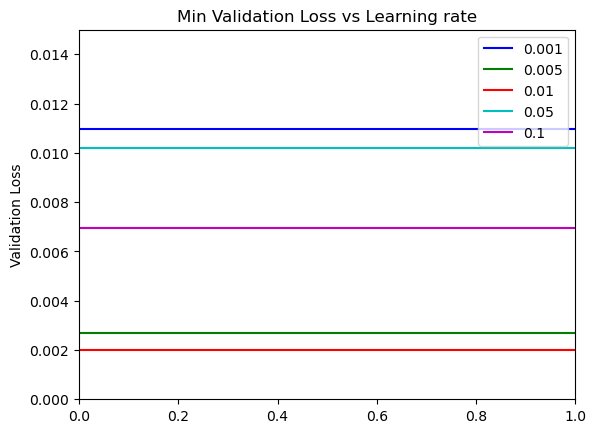

In [81]:
c = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i in range(len(final_errors_for_lrates)):
    
    lr = learning_rates[i]
    val_loss_value = final_errors_for_lrates[i]
    plt.axhline(y=val_loss_value, label=lr, color=c[i])

plt.ylabel('Validation Loss')
plt.title('Min Validation Loss vs Learning rate')
plt.ylim(0, 0.015)
plt.legend()
plt.show()

In [85]:
# Thus we have best learning rate = 0.002. Now we shall train the model with the best hyperparameters.

best_learning_rate = 0.002
best_lookback = 10

### Model Training

In [86]:
model = LSTM(1, 64, 1, best_lookback).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_learning_rate)

train_loader, val_loader, test_loader = model.prepare_loaders_for_lstm(df)

train_losses = []
val_losses = []

for epoch in range(epochs):
        
    model, train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer)
    val_loss = validate_one_epoch(model, val_loader, loss_fn)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch: {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}")

Epoch: 0, Train Loss: 0.1028706965347131, Val Loss: 0.1928860992193222
Epoch: 1, Train Loss: 0.026718993205577135, Val Loss: 0.018287370447069407
Epoch: 2, Train Loss: 0.022699677074948948, Val Loss: 0.062275176867842674
Epoch: 3, Train Loss: 0.014837022870779037, Val Loss: 0.07671198807656765
Epoch: 4, Train Loss: 0.014913643865535656, Val Loss: 0.05381404608488083
Epoch: 5, Train Loss: 0.013167453153679768, Val Loss: 0.03836648352444172
Epoch: 6, Train Loss: 0.012612626732637485, Val Loss: 0.04360164329409599
Epoch: 7, Train Loss: 0.011419084932034215, Val Loss: 0.043028878048062325
Epoch: 8, Train Loss: 0.011189590518673262, Val Loss: 0.03522627940401435
Epoch: 9, Train Loss: 0.01071419931637744, Val Loss: 0.03068270767107606
Epoch: 10, Train Loss: 0.009191372587035099, Val Loss: 0.021975817158818245
Epoch: 11, Train Loss: 0.008623596436033646, Val Loss: 0.020389328827150166
Epoch: 12, Train Loss: 0.0074297779550155, Val Loss: 0.02007576439063996
Epoch: 13, Train Loss: 0.00624663421

In [89]:
pickle.dump(model, open('best_lstm_model.pkl', 'wb'))

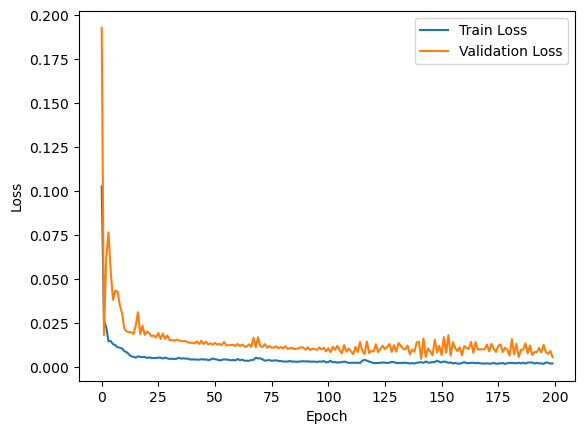

In [87]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model Testing

In [97]:
model.eval()
all_predictions = []
all_targets = []

running_mse = 0.0
running_rmse = 0.0
running_mape = 0.0

with torch.no_grad():
    
    for inputs, labels in val_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        mse_loss = nn.MSELoss()(outputs, labels)
        running_mse += mse_loss.item() * inputs.size(0)

        rmse_loss = torch.sqrt(mse_loss)
        running_rmse += rmse_loss.item() * inputs.size(0)

        mape_loss = torch.mean(torch.abs((labels - outputs) / labels)) * 100
        running_mape += mape_loss.item() * inputs.size(0)

        all_predictions.extend(outputs.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

print("Testing losses -")
print("MSE =", running_mse / len(val_loader.dataset),"\n")
print("RMSE =", running_rmse / len(val_loader.dataset),"\n")
print("MAPE =", running_mape / len(val_loader.dataset),"%")

Testing losses -
MSE = 0.007447147657248107 

RMSE = 0.08335893905975601 

MAPE = 11.724553455005992 %


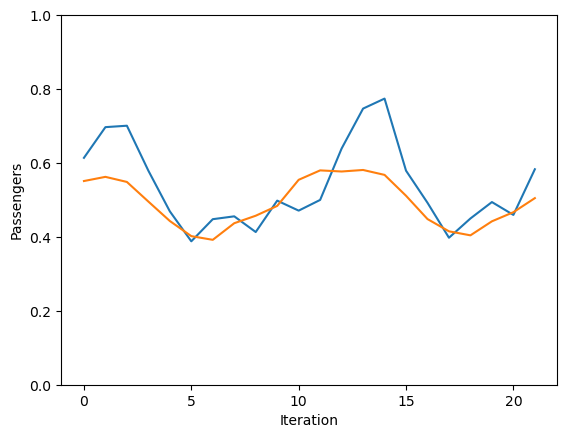

In [101]:
plt.plot(all_targets, label='Actual')
plt.plot(all_predictions, label='Predicted')
plt.xlabel('Iteration')
plt.ylabel('Passengers')
plt.ylim(0,1)
plt.show()